In [155]:
def reconstruct_currents_from_h5(filename: str, cathode: bool = False, from_frac: float = 0.0, until_frac: float = 1.0):
    """
    Recompute measuring electrode currents for a selected time interval from a saved HDF5 run.

    Parameters:
    - filename: path to the HDF5 file
    - from_frac: start fraction of the time span in [0,1]
    - until_frac: end fraction of the time span in [0,1]

    Returns:
    - currents: np.ndarray of shape (Tsel, 3) with currents for the three measuring electrodes per time step.
    - measuring_indices: tuple of the three node indices used for measurement.
    """
    import numpy as np
    from utils.fem_mesh import TetrahedralMesh

    # Open H5 lazily
    reader = PongH5Reader(filename)
    try:
        # Mesh
        nodes = reader.nodes[...]
        elements = reader.elements[...]
        mesh = TetrahedralMesh(nodes, elements)

        # Constants
        const = reader.constants
        R = float(const.get("R"))
        T = float(const.get("T"))
        F = float(const.get("F"))
        D1 = float(const.get("D1"))
        D2 = float(const.get("D2"))
        z1 = int(const.get("z1"))
        z2 = int(const.get("z2"))
        c0 = float(const.get("c0"))
        phi_c = R * T / F  # thermal voltage

        # Grid sizes to reconstruct measuring electrode node indices
        nx = int(reader.attrs.get("nx"))
        ny = int(reader.attrs.get("ny"))
        nz = int(reader.attrs.get("nz"))

        def get_node_idx(i, j, k):
            return i * (ny + 1) * (nz + 1) + j * (nz + 1) + k

        # Measuring electrodes: bottom row at x = nx//4, y in {ny//4, 2*ny//4, 3*ny//4}, k=0
        if cathode: 
            z_idx = nz
        else:
            z_idx = 0
        
        measuring_indices = (
            get_node_idx(nx // 4, ny // 4, z_idx),
            get_node_idx(nx // 4, 2 * ny // 4, z_idx),
            get_node_idx(nx // 4, 3 * ny // 4, z_idx),
        )

        # Precompute connected elements per node
        node_to_elements = [[] for _ in range(mesh.num_nodes())]
        for elem_idx in range(mesh.num_cells()):
            elem_nodes = mesh.elements[elem_idx]
            for n in elem_nodes:
                node_to_elements[n].append(elem_idx)

        # Precompute constants for flux terms
        K_GRAD_C = (-D1 * c0, -D2 * c0)
        K_MIG = (-(z1 * F * D1 / (R * T)) * phi_c, -(z2 * F * D2 / (R * T)) * phi_c)

        # Precompute incident faces (unit normals, areas) per measuring node
        def build_node_faces(node_idx):
            faces_per_elem = []
            p_i = mesh.nodes[node_idx]
            for elem_idx in node_to_elements[node_idx]:
                if elem_idx not in mesh._element_data:
                    continue
                elem_nodes = mesh.elements[elem_idx]
                # local index of node in element
                try:
                    local_i = int(np.where(elem_nodes == node_idx)[0][0])
                except Exception:
                    continue
                others = [j for j in range(4) if j != local_i]
                face_pairs = [
                    (others[0], others[1], others[2]),
                    (others[0], others[2], others[1]),
                    (others[1], others[2], others[0]),
                ]
                face_list = []
                for a, b, opp in face_pairs:
                    p_a = mesh.nodes[elem_nodes[a]]
                    p_b = mesh.nodes[elem_nodes[b]]
                    p_opp = mesh.nodes[elem_nodes[opp]]
                    v1 = p_a - p_i
                    v2 = p_b - p_i
                    normal = np.cross(v1, v2)
                    if np.dot(normal, (p_opp - p_i)) > 0.0:
                        normal = -normal
                    normn = np.linalg.norm(normal)
                    if normn < 1e-18:
                        continue
                    area = 0.5 * normn
                    unit_normal = normal / normn
                    face_list.append((unit_normal, area))
                if face_list:
                    faces_per_elem.append((elem_idx, face_list))
            return faces_per_elem

        node_faces = {idx: build_node_faces(idx) for idx in measuring_indices}

        # Determine time selection
        Tlen = reader.c.shape[0]
        from_frac = float(from_frac)
        until_frac = float(until_frac)
        # clamp to [0,1]
        from_frac = 0.0 if from_frac < 0.0 else (1.0 if from_frac > 1.0 else from_frac)
        until_frac = 0.0 if until_frac < 0.0 else (1.0 if until_frac > 1.0 else until_frac)
        # ensure order
        if until_frac < from_frac:
            from_frac, until_frac = until_frac, from_frac
        t0 = int(np.floor(Tlen * from_frac))
        t1 = int(np.ceil(Tlen * until_frac))
        # clamp indices
        t0 = max(0, min(Tlen, t0))
        t1 = max(0, min(Tlen, t1))
        if t1 <= t0:
            return np.zeros((0, 3), dtype=float), measuring_indices

        currents = np.zeros((t1 - t0, 3), dtype=float)
        diff_currents = np.zeros((t1 - t0, 3), dtype=float)
        mig_currents = np.zeros((t1 - t0, 3), dtype=float)

        for ti, t in enumerate(range(t0, t1)):
            c = reader.c[t]
            phi = reader.phi[t]

            # For each measuring node, integrate J·n over incident faces
            for m, electrode_node_idx in enumerate(measuring_indices):
                total_current = 0.0
                total_diff = 0.0
                total_mig = 0.0
                for elem_idx, face_list in node_faces[electrode_node_idx]:
                    if elem_idx not in mesh._element_data:
                        continue
                    elem_nodes_indices = mesh.elements[elem_idx]

                    c_local = c[elem_nodes_indices]
                    phi_local = phi[elem_nodes_indices]
                    grads = mesh._element_data[elem_idx]["grads"]

                    grad_c = np.dot(c_local, grads)
                    grad_phi = np.dot(phi_local, grads)
                    c_avg_phys = float(np.mean(c_local) * c0)

                    J_diff = z1 * (K_GRAD_C[0] * grad_c) + z2 * (K_GRAD_C[1] * grad_c)
                    J_mig = z1 * (K_MIG[0] * c_avg_phys * grad_phi) + z2 * (K_MIG[1] * c_avg_phys * grad_phi)
                    J_elem = F * (J_diff + J_mig)

                    for unit_normal, face_area in face_list:
                        current_through_face = float(np.dot(J_elem, unit_normal)) * face_area
                        current_diff = float(np.dot(J_diff, unit_normal)) * face_area
                        current_mig = float(np.dot(J_mig, unit_normal)) * face_area

                        total_diff += current_diff / 3.0
                        total_mig += current_mig / 3.0
                        total_current += current_through_face / 3.0

                currents[ti, m] = total_current
                diff_currents[ti, m] = total_diff
                mig_currents[ti, m] = total_mig

        return currents, measuring_indices, diff_currents, mig_currents
    finally:
        reader.close()


In [156]:
def global_init(filename: str):
    is_npen = "npen" in h5_path.lower()
    if is_npen:
        from pong_simulation.pong_sim_npen import PongH5Reader as Reader
        default_species = ("c",) if species is None else species
    else:
        from pong_simulation.pong_simulation import PongH5Reader as Reader
        default_species = ("c1", "c2", "c3") if species is None else species
    
    with Reader(filename) as data:
        nodes = data.mesh.nodes
        elements = data.mesh.elements
        voltage_pattern = data.electrodes.voltage_pattern
        measured_current = data.measurements.measured_current
        game = data.game


In [157]:
filename = "metasimulation/PC4/pong_sim_npen_rlT_s1_g1_dt0p005_k0p0_1757018114602110500.h5"
filename = "metasimulation/PC3/pong_sim_s3_g1_dt0p0005_k0p0_1756920498004680800.h5"
filename = "metasimulation/PC2/memory/mem_idle0_volt1000_tot2000_amp1p0_expgradientx_t1,1,2,0_nocp_1759544434699056000.h5"

In [158]:
filename = "metasimulation/output/memory/mem_idle100_volt200_tot1000_amp1p0_Lc0p01_expgradientx-_blk(0;1;id)_0.001_nocp_1759929900070857133.h5"

In [159]:
import numpy as np
import matplotlib.pyplot as plt

def plot_concentration_sums(h5_path, species=None, include_total=True, npen=False):
    """
    Auto-selects the appropriate PongH5Reader based on filename:
      - If 'npen' in path (case-insensitive): use NPEN reader and sum 'c' (and optionally 'c3').
      - Else: use NPP reader and sum 'c1','c2','c3' by default.

    Args:
        h5_path (str): Path to .h5 file.
        species (tuple[str]|None): Override datasets to sum. If None, defaults per mode.
        include_total (bool): Whether to plot total across selected species.

    Returns:
        times (np.ndarray)
        sums_dict (dict): per-species and optionally "total"
        fig, ax
    """
    is_npen = "npen" in h5_path.lower()
    if is_npen or npen:
        from pong_simulation.pong_sim_npen import PongH5Reader as Reader
        default_species = ("c",) if species is None else species
        primary_ds = "c"
    else:
        from pong_simulation.pong_simulation import PongH5Reader as Reader
        default_species = ("c1", "c2", "c3") if species is None else species
        primary_ds = default_species[0]

    with Reader(h5_path) as rdr:
        # Filter to species that actually exist in the file (robust to older files)
        valid_species = tuple(sp for sp in default_species if hasattr(rdr, sp))
        if not valid_species:
            raise ValueError(f"No requested species found in file. Requested: {default_species}")

        # Determine length and time axis
        T = getattr(rdr, primary_ds).shape[0]
        print(f"Dataset length (timesteps): {T}")
        dt = rdr.attrs.get("dt", None)
        times = np.arange(T) * dt if dt is not None else np.arange(T)

        # Compute sums lazily
        sums_dict = {sp: np.zeros(T, dtype=np.float64) for sp in valid_species}
        for t in range(T):
            for sp in valid_species:
                ds = getattr(rdr, sp)
                sums_dict[sp][t] = float(np.nansum(ds[t]))

        if include_total and len(valid_species) > 1:
            total = np.zeros(T, dtype=np.float64)
            for sp in valid_species:
                total += sums_dict[sp]
            sums_dict["total"] = total

    # Plot
    fig, ax = plt.subplots(figsize=(8, 4.5))
    for sp in valid_species:
        ax.plot(times, sums_dict[sp], label=f"{sp} sum")
    if include_total and "total" in sums_dict:
        ax.plot(times, sums_dict["total"], label="total", color="k", linewidth=2.2)

    ax.set_xlabel("time (s)" if dt is not None else "timestep")
    ax.set_ylabel("sum over nodes")
    ax.set_title(("NPEN" if is_npen else "NPP") + " concentration sums over time")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    return times, sums_dict, fig, ax

Dataset length (timesteps): 1001


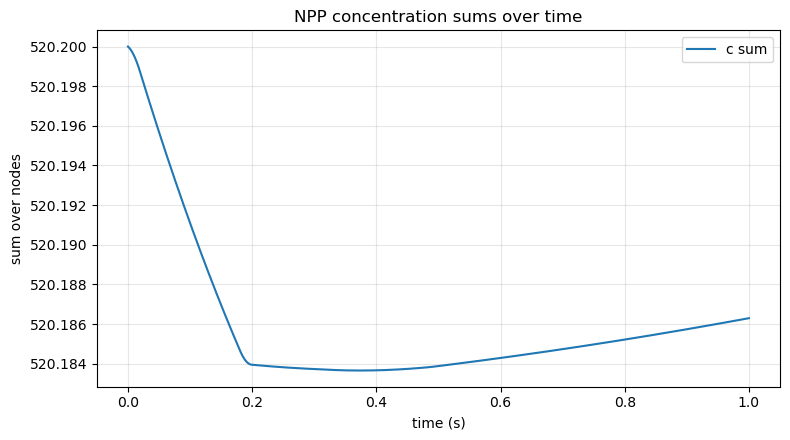

In [160]:
times, sums, fig, ax = plot_concentration_sums(filename, species=["c"], npen=True)

In [161]:
import numpy as np
import matplotlib.pyplot as plt

def plot_concentration_change_norm_over_time(
    h5_path: str,
    species: tuple | None = None,
    norm: str = "l2",   # "l2" or "l1"
    include_points: bool = False,
    is_npen = True
):
    """
    Plots the norm of the total amount of change in concentration per timestep over time.
    
    - Auto-selects reader by filename containing 'npen' (case-insensitive).
    - For each timestep t >= 1, computes Δ = concat_s [ vec( c_s(t) - c_s(t-1) ) ] over selected species s.
    - Norm options:
        "l2": sqrt(sum(Δ^2))  [default]
        "l1": sum(|Δ|)
    - Uses lazy reading (does not load full datasets into memory).

    Returns:
        times (np.ndarray): time axis aligned with t>=1 (size T-1)
        change_norm (np.ndarray): norm per timestep (size T-1)
        fig, ax
    """
    
    if is_npen:
        from pong_simulation.pong_sim_npen import PongH5Reader as Reader
        default_species = ("c",) if species is None else species
    else:
        from pong_simulation.pong_simulation import PongH5Reader as Reader
        default_species = ("c1", "c2", "c3") if species is None else species

    with Reader(h5_path) as rdr:
        # Filter to existing datasets for robustness
        valid_species = tuple(sp for sp in default_species if hasattr(rdr, sp))
        if not valid_species:
            raise ValueError(f"No requested species found in file. Requested: {default_species}")

        # Establish length and time axis (t=0..T-1 -> diffs at 1..T-1)
        T = getattr(rdr, valid_species[0]).shape[0]
        if T < 2:
            raise ValueError("Need at least 2 timesteps to compute per-timestep change.")
        dt = rdr.attrs.get("dt", None)
        times = (np.arange(1, T) * dt) if dt is not None else np.arange(1, T)

        # Prepare arrays
        change_norm = np.zeros(T - 1, dtype=np.float64)

        # Load t=0 baseline for all species lazily
        prev = {sp: np.array(getattr(rdr, sp)[0], dtype=np.float64) for sp in valid_species}

        # Iterate timesteps and compute norm of concatenated diffs
        for t in range(1, T):
            diffs = []
            for sp in valid_species:
                cur = np.array(getattr(rdr, sp)[t], dtype=np.float64)
                d = cur - prev[sp]
                if norm == "l1":
                    diffs.append(np.abs(d))
                else:  # l2 (default)
                    diffs.append(d)
                prev[sp] = cur  # advance baseline
            if norm == "l1":
                change_norm[t - 1] = float(np.nansum(np.concatenate(diffs)))
            else:
                vec = np.concatenate(diffs)
                change_norm[t - 1] = float(np.sqrt(np.nansum(vec * vec)))

    # Plot
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.scatter(times, change_norm, label=f"||Δc||_{norm}", lw=2)
    if include_points:
        ax.scatter(times, change_norm, s=8, alpha=0.6)

    ax.set_xlabel("time (s)" if dt is not None else "timestep")
    ax.set_ylabel(f"norm of Δc per step ({norm})")
    ax.set_title(("NPEN" if is_npen else "NPP") + f" per-step concentration change norm ({norm})")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    return times, change_norm, fig, ax

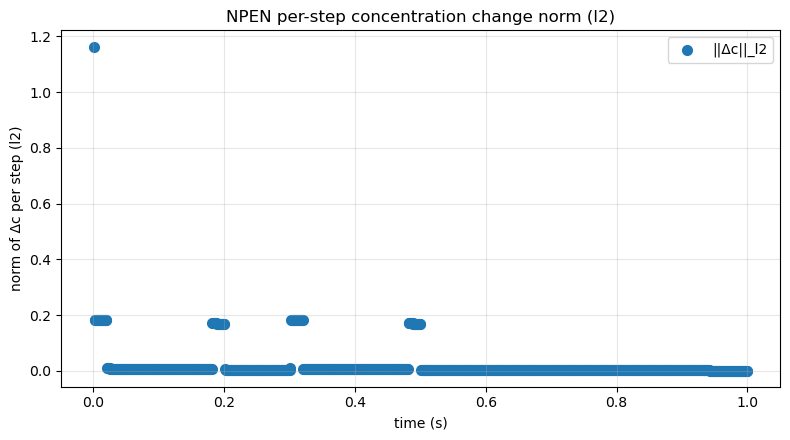

In [162]:
times, dnorm, fig, ax = plot_concentration_change_norm_over_time(
    filename, 
    species=("c")
)

In [163]:
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt

from pong_simulation.pong_sim_npen import PongH5Reader


def plot_currents(h5_path: str,
                  ax: Optional[plt.Axes] = None,
                  from_frac: float = 0.0,
                  until_frac: float = 1.0, 
                  paddle_change: bool = False) -> plt.Axes:
    """Plot the 3 measurement currents vs time from a pong .h5 file, with paddle position.

    Parameters:
    - h5_path: path to the HDF5 file produced by the simulation
    - ax: optional Matplotlib Axes to draw on; if None, a new figure/axes is created
    - from_frac: start of the time window as a fraction in [0,1]
    - until_frac: end of the time window as a fraction in [0,1], must be > from_frac

    Returns:
    - The Matplotlib Axes with the plot
    """
    # Validate window fractions
    if not (0.0 <= from_frac <= 1.0) or not (0.0 <= until_frac <= 1.0):
        raise ValueError("from_frac and until_frac must be between 0 and 1 (inclusive)")
    if from_frac >= until_frac:
        raise ValueError("from_frac must be less than until_frac")

    with PongH5Reader(h5_path) as data:
        I_full = np.asarray(data.measured_current[...], dtype=float)  # (T, 3)
        paddle_full = np.asarray(data.platform_pos[...], dtype=float)  # (T,)
        dt = float(data.attrs.get('dt', 0.0))

    T = I_full.shape[0]
    # Build full time base
    if dt > 0 and np.isfinite(dt):
        t_full = np.arange(T, dtype=float) * dt
        x_label = 'time (s)'
    else:
        t_full = np.arange(T, dtype=float)
        x_label = 'time (steps)'

    # Determine slice window [start_idx:end_idx)
    start_idx = int(np.floor(from_frac * T))
    end_idx = int(np.ceil(until_frac * T))
    start_idx = max(0, min(start_idx, T))
    end_idx = max(0, min(end_idx, T))
    if end_idx - start_idx <= 0:
        raise ValueError("Slicing range is empty after applying from_frac/until_frac")

    # Slice window first, then drop NaN rows based on current measurements
    I = I_full[start_idx:end_idx]
    t = t_full[start_idx:end_idx]
    paddle = paddle_full[start_idx:end_idx]

    good = np.isfinite(I).all(axis=1)
    I = I[good]
    t = t[good]
    paddle = paddle[good]


    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(9, 4.8))


    if not paddle_change:
        l1, = ax.plot(t, I[:, 0], label='I2', color='#1f77b4', alpha=1, linestyle='-')
        l2, = ax.plot(t, I[:, 1], label='I1', color='#ff7f0e', alpha=1, linestyle='-')
        l3, = ax.plot(t, I[:, 2], label='I0', color='#2ca02c', alpha=1, linestyle='-')
        ax.set_xlabel(x_label)
        ax.set_ylabel('Current (A)')
        ax.grid(True, alpha=0.3)

        # Secondary axis for paddle position (pixels)
        ax2 = ax.twinx()
        l4, = ax2.plot(t, paddle, label='Paddle Y', color='#d62728', alpha=1, linestyle='--')
        ax2.set_ylabel('Paddle position (px)')

        # Combined legend
        lines = [l1, l2, l3, l4]
        labels = [ln.get_label() for ln in lines]
        ax.legend(lines, labels, loc='best')

        ax.set_title('Measurement currents and paddle position')
    else:

        change = np.abs(paddle[:-1]-paddle[1:])
        #ax.plot(t[:-1], change, label='Paddle change', color='#d62728', alpha=0.4, linestyle='--')
        ax.set_xlabel(x_label)
        ax.set_ylabel('Paddle change (px)')
        ax.grid(True, alpha=0.3)

        # plot moving average in blue
        window_size = 20
        moving_avg = np.convolve(change, np.ones(window_size)/window_size, mode='valid')
        ax.plot(t[window_size//2:-window_size//2], moving_avg, label='Paddle change (moving average)', color='#1f77b4', alpha=0.4, linestyle='-')
        

    return ax, t, I, paddle



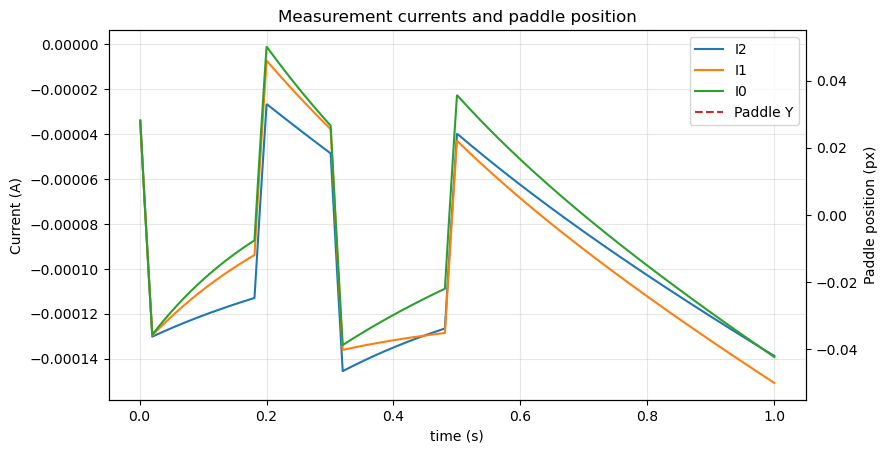

In [164]:
from_frac = 0.0
until_frac = 1.0

_, t, I, paddle = plot_currents(filename, from_frac=from_frac, until_frac=until_frac)

/home/dani/miniconda3/envs/sim_env/lib/python3.13/site-packages/matplotlib/axes/_axes.py:7101: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/dani/miniconda3/envs/sim_env/lib/python3.13/site-packages/matplotlib/axes/_axes.py:7102: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

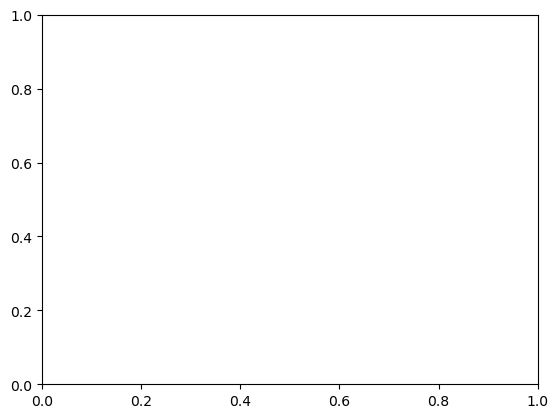

In [165]:
plt.hist(paddle)
plt.show()


0
[4.53497564e-06 1.67522688e-06 3.11505551e-07]


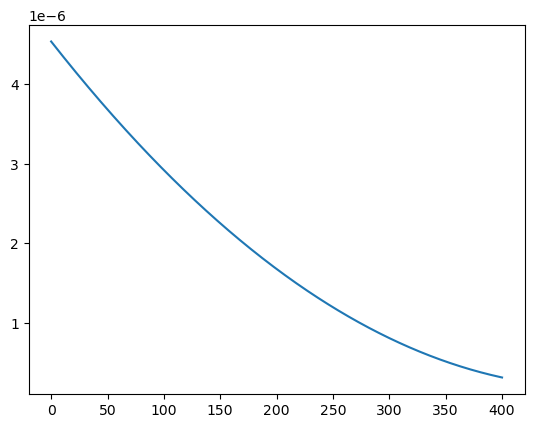

In [ ]:
timepoint = 1*len(I)//4 + 0
a,b,c = np.polyfit([0, 200, 400], np.abs(I[timepoint]), 2)
x_space = np.linspace(0, 400, 400)
y_space = a*x_space**2 + b*x_space + c

print(np.argmax(y_space))
print(I[timepoint])
plt.plot(x_space, y_space)
plt.show()


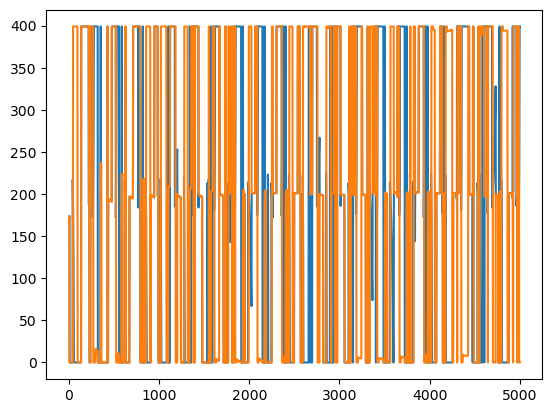

In [ ]:
max_poly = np.zeros(len(I))
x_space = np.linspace(0, 400, 400)
for timestep in range(len(I)):
    Is = np.abs(I[timestep])/np.sum(I[timestep])
    a,b,c = np.polyfit([0, 200, 400], Is, 2)
    max_poly[timestep] = np.argmax(a*x_space**2 + b*x_space)

plt.plot(max_poly)
plt.plot(paddle)
plt.show()


    
    

In [ ]:
currents, measuring_indices, diff_currents, mig_currents = reconstruct_currents_from_h5(filename, cathode=True, from_frac=from_frac, until_frac=until_frac)

Text(0.5, 1.0, 'Measurement from concentration data')

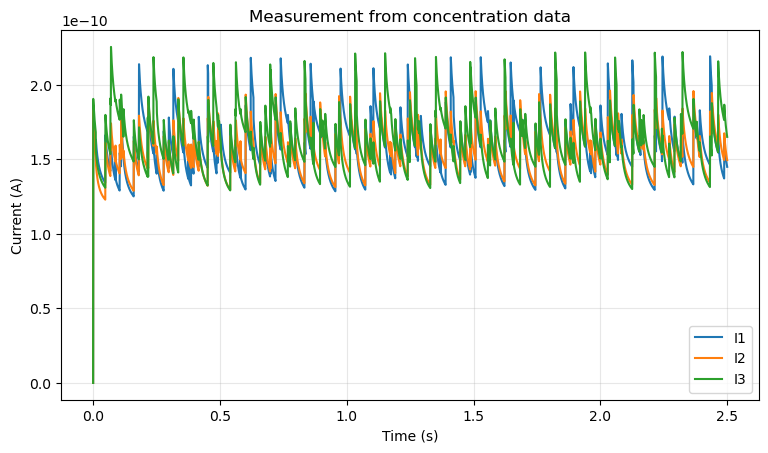

In [ ]:

_, ax = plt.subplots(1, 1, figsize=(9, 4.8))


l1, = ax.plot(t, mig_currents[:-1, 0], label='I1', color='#1f77b4')
l2, = ax.plot(t, mig_currents[:-1, 1], label='I2', color='#ff7f0e')
l3, = ax.plot(t, mig_currents[:-1, 2], label='I3', color='#2ca02c')

ax.set_xlabel("Time (s)")
ax.set_ylabel('Current (A)')
ax.grid(True, alpha=0.3)

# Combined legend
lines = [l1, l2, l3]
labels = [ln.get_label() for ln in lines]
ax.legend(lines, labels, loc='best')

ax.set_title('Measurement from concentration data')

In [ ]:
np.sum(diff_currents[:, 2])

np.float64(0.0)

In [ ]:
len(diff_currents)

5001